# Introduction

Explore the GPU memory usage under different input sequence length and gradient checkpointing.

In [1]:
from pathlib import Path
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
os.environ['HF_HUB_CACHE'] = '/next_share/hf_cache/hub'
import json
import numpy as np
from datasets import Dataset
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, PreTrainedModel, AutoModelForSeq2SeqLM, 
    AutoModelForSequenceClassification, AutoConfig, AutoModel, BitsAndBytesConfig
)
from peft import get_peft_model, LoraConfig, get_peft_model_state_dict, AutoPeftModelForCausalLM
from collections import defaultdict
import inspect
import time

from pynvml import *
import matplotlib.pyplot as plt

In [2]:
AUTO_NAME_MAP = {'cls': AutoModelForSequenceClassification,
                 'causal': AutoModelForCausalLM,
                 'seq2seq': AutoModelForSeq2SeqLM}

def build_model(model_name, 
                auto_cls = None, lora = False, dtype = torch.bfloat16, 
                device_map = None, quantization = False):
    mod_cls = AUTO_NAME_MAP.get(auto_cls, AutoModelForCausalLM)
    if device_map is None:
        device_map = 0
    if quantization:
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    else:
        quant_config = None
    model = mod_cls.from_pretrained(model_name, 
                                    torch_dtype = dtype, device_map = device_map,
                                    quantization_config = quant_config)
    if lora:
        peft_config = LoraConfig(
            r = 16, lora_alpha = 16,
            target_modules = 'all-linear',
            lora_dropout= 0.1,
            bias = "none"
        )

        model = get_peft_model(model, peft_config)
        model.print_trainable_parameters()
    return model

class NVML_Mem:
    """Get GPU Memory Usage"""
    def __init__(self, gpu_indexes = None):
        if gpu_indexes is not None:
            self.gpu_indexes = gpu_indexes
        elif 'CUDA_VISIBLE_DEVICES' in os.environ:
            self.gpu_indexes = [int(k) for k in os.environ['CUDA_VISIBLE_DEVICES'].split(',')]
        else:
            self.gpu_indexes = list(range(torch.cuda.device_count()))
        nvmlInit()
    
    def __call__(self):
        return [self.get_mem_by_id(k) for k in self.gpu_indexes]
    
    def get_mem_by_id(self, index):
        h = nvmlDeviceGetHandleByIndex(index)
        info = nvmlDeviceGetMemoryInfo(h)
        return info.used / 1024**3

def training_step(model, batch, optim):
    model.train()
    batch = {k:v.cuda() for k,v in batch.items()}
    loss = model(**batch).loss
    loss.backward()
    optim.step()
    optim.zero_grad()

def get_dummy_inputs(seq_len = 512, batch_size = 1, is_cls = False):
    input_ids = torch.randint(100, 3000, (batch_size, seq_len))
    if is_cls:
        labels = torch.randint(0, 1, (batch_size,))
    else:
        labels = input_ids
    return {'input_ids': input_ids, 'labels': labels}

def handle_grad_ckpt(model, gradient_checkpointing):
    if gradient_checkpointing:
        model.enable_input_require_grads()
        model.gradient_checkpointing_enable()
    else:
        model.gradient_checkpointing_disable()

def get_mem_usage_of_input_len(
    model, per_step, num_steps, 
    gradient_checkpointing = False, 
    batch_size = 1,
    is_cls = False
):
    """Increase input_len by per_step and get memory usage."""
    torch.cuda.empty_cache()
    # set gradient checkpointing
    handle_grad_ckpt(model, gradient_checkpointing)
    optim = torch.optim.AdamW(model.parameters(), lr = 0.01)
    mem_usage_list = [NVML_Mem()()]
    for i in range(1, num_steps + 1):
        ipt_len = per_step * i
        batch = get_dummy_inputs(ipt_len, batch_size, is_cls)
        training_step(model, batch, optim)
        mem_usage_list.append(NVML_Mem()())
    return mem_usage_list

def plot_mem_list(mem_list):
    mems = np.array(mem_list)
    x = np.arange(mems.shape[0])
    for col in range(mems.shape[1]):
        plt.plot(x, mems[:,col], color = f'C{col}', label = f'GPU {col}')
    plt.xticks(x, x)
    plt.legend()

def get_training_time(model, input_len, steps = 10,gradient_checkpointing = False, 
                      batch_size = 1, is_cls = False):
    torch.cuda.empty_cache()
    # set gradient checkpointing
    handle_grad_ckpt(model, gradient_checkpointing)
    optim = torch.optim.AdamW(model.parameters(), lr = 0.01)

    batch = get_dummy_inputs(input_len, batch_size, is_cls)
    start = time.time()
    for _ in tqdm(list(range(steps))):
        training_step(model, batch, optim)
    dur = time.time() - start
    return dur

In [3]:
# Customized device_map to equally distribute layers among 2 gpus
devmap_7b2gpu = {'model.embed_tokens': 0,
              'model.norm': 1,
              'lm_head': 1}
devmap_7b2gpu.update({f'model.layers.{i}': 0 if i < 16 else 1 for i in range(32)})

In [3]:
# Build LLaMA3
model = build_model('meta-llama/Meta-Llama-3-8B', auto_cls = 'causal',lora = True, device_map = devmap_7b2gpu)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5195983464188562


In [3]:
# model = build_model('mistralai/Mixtral-8x7B-v0.1', auto_cls = 'causal',lora = True, device_map = 'auto', quantization=False)
model = build_model('mistralai/Mistral-7B-v0.1', auto_cls = 'causal',lora = True, device_map = 'auto', quantization=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 41,943,040 || all params: 7,283,675,136 || trainable%: 0.5758499550960753


In [4]:
for name, p in model.base_model.model.model.layers[0].named_parameters():
    print(f'{name}: {p.shape} {p.device}')

self_attn.q_proj.base_layer.weight: torch.Size([4096, 4096]) cuda:0
self_attn.q_proj.lora_A.default.weight: torch.Size([16, 4096]) cuda:0
self_attn.q_proj.lora_B.default.weight: torch.Size([4096, 16]) cuda:0
self_attn.k_proj.base_layer.weight: torch.Size([1024, 4096]) cuda:0
self_attn.k_proj.lora_A.default.weight: torch.Size([16, 4096]) cuda:0
self_attn.k_proj.lora_B.default.weight: torch.Size([1024, 16]) cuda:0
self_attn.v_proj.base_layer.weight: torch.Size([1024, 4096]) cuda:0
self_attn.v_proj.lora_A.default.weight: torch.Size([16, 4096]) cuda:0
self_attn.v_proj.lora_B.default.weight: torch.Size([1024, 16]) cuda:0
self_attn.o_proj.base_layer.weight: torch.Size([4096, 4096]) cuda:0
self_attn.o_proj.lora_A.default.weight: torch.Size([16, 4096]) cuda:0
self_attn.o_proj.lora_B.default.weight: torch.Size([4096, 16]) cuda:0
mlp.gate_proj.base_layer.weight: torch.Size([14336, 4096]) cuda:0
mlp.gate_proj.lora_A.default.weight: torch.Size([16, 4096]) cuda:0
mlp.gate_proj.lora_B.default.weight

In [6]:
print(model.hf_device_map)

{'model.embed_tokens': 0, 'model.layers.0': 0, 'model.layers.1': 0, 'model.layers.2': 0, 'model.layers.3': 0, 'model.layers.4': 0, 'model.layers.5': 0, 'model.layers.6': 1, 'model.layers.7': 1, 'model.layers.8': 1, 'model.layers.9': 1, 'model.layers.10': 1, 'model.layers.11': 1, 'model.layers.12': 1, 'model.layers.13': 2, 'model.layers.14': 2, 'model.layers.15': 2, 'model.layers.16': 2, 'model.layers.17': 2, 'model.layers.18': 2, 'model.layers.19': 2, 'model.layers.20': 3, 'model.layers.21': 3, 'model.layers.22': 3, 'model.layers.23': 3, 'model.layers.24': 3, 'model.layers.25': 3, 'model.layers.26': 3, 'model.layers.27': 'cpu', 'model.layers.28': 'cpu', 'model.layers.29': 'cpu', 'model.layers.30': 'cpu', 'model.layers.31': 'cpu', 'model.norm': 'cpu', 'lm_head': 'cpu'}


In [7]:
mem_list = get_mem_usage_of_input_len(model, 128, 3, gradient_checkpointing=True)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


RuntimeError: Function MmBackward0 returned an invalid gradient at index 1 - expected device meta but got cuda:0

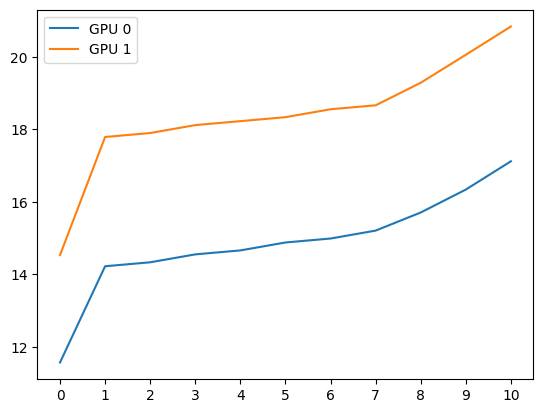

In [12]:
plot_mem_list(mem_list)

In [13]:
get_training_time(model, input_len = 1200, steps = 10, gradient_checkpointing=True)

100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


31.221932411193848

In [11]:
get_training_time(model, input_len = 512, steps = 10, gradient_checkpointing=False)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


11.660600662231445

In [14]:
NVML_Mem()()

[15.0128173828125, 18.1729736328125]